# Figure 5. SRSF3 is a global regulatory factor
A. Global change induced by SRSF3   
B. Clustering  
C. Classification changes  
D. SRSF3-responsive element - tetramer motifs  
E. SRSF3-responsive element - sequence content  
F. Secondary structure of SRSF3-responsive miRNAs  
G. Primary sequence motifs of SRSF3-dependent miRNAs  
H. Comparison with DROSHA fCLIP-seq sites

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201013/


In [4]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec, colors
from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import sem, ttest_ind
from sequtil import nmer
import statsmodels.api as sm
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

#### Import supplementary tables

In [6]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201012_s6_cleavage-patterns.csv', header=1, index_col=0)
s7 = pd.read_csv('supplementary/201012_s7_cleavage-sites.csv', header=1, index_col=0)
s8 = pd.read_csv('supplementary/201012_s8_cleavage-patterns-srsf3.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's5:\t%s'%', '.join(list(s5.columns)[-10:])
print 's6:\t%s'%', '.join(list(s6.columns)[-4:])
print 's7:\t%s'%', '.join(list(s7.columns))
print 's8:\t%s'%', '.join(list(s8.columns))

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s5:	117, 118, 119, 120, 121, 122, 123, 124, 125, symbolized structure
s6:	Relative position from miRBase site, Cleavage Specificity, Cleavage Imbalance, Cleavage type
s7:	Chr, miRBase 5' site, miRBase 3' site, IVP 5' site, IVP 3' site, fCLIP 5' site, fCLIP 3' site, Strand, Type, IVP PCS, fCLIP PCS
s8:	Chr, 5' cleavage site, 3' cleavage site, Strand, Cleavage type, CP_wo_SRSF3, CP_w_SRSF3, CS_wo_SRSF3, CS_w_SRSF3, Productive_wo_SRSF3, Productive_w_SRSF3, Alternative_wo_SRSF3, Alternative_w_SRSF3, Nick_wo_SRSF3, Nick_w_SRSF3, Inverted_wo_SRSF3, Inverted_w_SRSF3


In [7]:
def get_pre_position(pri):
    constructseq = s2.loc[pri, 'Construct sequence'].replace('T','U')
    seq5p = s1.loc[pri, '5p sequence']
    seq3p = s1.loc[pri, '3p sequence']
    if seq5p=='n.a.' or constructseq.find(seq5p)==-1:
        prestart = 0
    else:
        prestart = constructseq.find(seq5p)+1
    if seq3p=='n.a.' or constructseq.find(seq3p)==-1:
        preend = 125
    else:
        preend = constructseq.rfind(seq3p)+len(seq3p)
    return prestart, preend

In [8]:
allpris = s1.index
preposition = { pri:get_pre_position(pri) for pri in allpris }
print len(preposition)

1881


In [9]:
mirtrons = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Mirtron')>=0 ]
capped = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Capped miRNA')>=0 ]
drosensitive = [ pri for pri in allpris if s1.loc[pri,'Note'].find('DROSHA KO-sensitive')>=0 ]
fclipdetected = [ pri for pri in allpris if s1.loc[pri,'Note'].find('fCLIP site-determined')>=0 ]
dbmirs = [ pri for pri in allpris if s1.loc[pri,'Note'].find('MirGeneDB')>=0 ]
print len(mirtrons), len(capped), len(drosensitive), len(fclipdetected), len(dbmirs)

239 11 157 281 519


In [10]:
constseqs = dict(s2['Construct sequence'])
print len(constseqs)

1881


In [11]:
singlemp = set(s6[s6['Cleavage type']=='single'].index)
multimp = set(s6[s6['Cleavage type']=='multiple'].index)
invertedmp = set(s6[s6['Cleavage type']=='inverted'].index)
nick5mp = set(s6[s6['Cleavage type']=='nick5'].index)
nick3mp = set(s6[s6['Cleavage type']=='nick3'].index)
nickmp = list(nick5mp) + list(nick3mp)
nonspecmp = set(s6[s6['Cleavage type']=='non-specific'].index)
dcsmirsmp = list(singlemp) + list(multimp)
nodcsmp = list(invertedmp) + list(nickmp) + list(nonspecmp)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirsmp), len(nodcsmp))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(singlemp), len(multimp), len(invertedmp), len(nickmp), len(nonspecmp))
print "5' nick: %s, 3' nick: %s" % (len(nick5mp), len(nick3mp))

Productive: 512, Unproductive: 1304
Single: 445, Multiple: 67, Inverted: 156, Nick: 107, Non-specific: 1041
5' nick: 72, 3' nick: 35


# A. Global change induced by SRSF3

In [14]:
def get_2d_density(data, xmin, xmax, ymin, ymax):
    x, y = zip(*data)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx, yy, f

In [15]:
s6sort = s6.sort_values('Cleavage Specificity')
pros = s6['Cleavage Productivity'].to_dict()
spes = s6sort[~s6sort.index.duplicated(keep='last')]['Cleavage Specificity'].to_dict()
srsf3pros = s8['CP_w_SRSF3'].to_dict()
srsf3spes = s8['CS_w_SRSF3'].to_dict()
overlap = [ m for m in pros if m in srsf3pros ]
print len(overlap)

1745


In [16]:
data1 = [ (pros[m],spes[m]) for m in overlap ]
data2 = [ (srsf3pros[m],srsf3spes[m]) for m in overlap ]
datacano1 = [ (pros[m],spes[m]) for m in overlap if m in drosensitive ]
xcano1, ycano1 = zip(*datacano1)
datacano2 = [ (srsf3pros[m],srsf3spes[m]) for m in overlap if m in drosensitive ]
xcano2, ycano2 = zip(*datacano2)
datacano3 = [ (pros[m],spes[m]) for m in overlap if m in mirtrons ]
xcano3, ycano3 = zip(*datacano3)
datacano4 = [ (srsf3pros[m],srsf3spes[m]) for m in overlap if m in mirtrons ]
xcano4, ycano4 = zip(*datacano4)

xmin, xmax = -3, 12
ymin, ymax = -.25, 1.1
xs1,ys1,f1 = get_2d_density(data1, xmin, xmax, ymin, ymax)
xs2,ys2,f2 = get_2d_density(data2, xmin, xmax, ymin, ymax)
blk = custom_cmap(['white','black'])
red = custom_cmap(['white','#a50f15'])

Text(9.1,0.1,u'N = 1745')

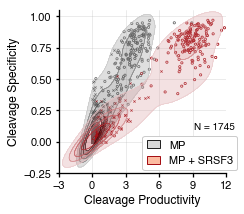

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.contourf(xs1,ys1,f1,levels=[.05,.15,.3,.6,.99],cmap=blk,alpha=.3,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs1,ys1,f1,levels=[.05,.15,.3,.6,.99],cmap=blk,linestyles='-',linewidths=.6,
          norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contourf(xs2,ys2,f2,levels=[.05,.15,.3,.6,.99],cmap=red,alpha=.3,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs2,ys2,f2,levels=[.05,.15,.3,.6,.99],cmap=red,linestyles='-',linewidths=.6,
          norm=colors.LogNorm(vmin=0.02, vmax=1), zorder=3)
ax.scatter(xcano1,ycano1,s=5,edgecolor='#666666',facecolor='None',lw=.8,zorder=2)
ax.scatter(xcano2,ycano2,s=5,edgecolor='#a50f15',facecolor='None',lw=.8,zorder=2)

ax.scatter(xcano4,ycano4,s=5,color='#a50f15',lw=.7,zorder=2,marker='x')
ax.scatter(xcano3,ycano3,s=5,color='#666666',lw=.7,zorder=2,marker='x')

ax.set_xticks(range(-3,13,3))
ax.set_yticks(np.arange(-.25,1.1,.25))
ax.set_xlim(-3,12)
ax.set_ylim(-.25,1.05)
ax.set_xlabel('Cleavage Productivity', fontsize=12)
ax.set_ylabel('Cleavage Specificity', fontsize=12)
ax.bar([-10],[0],edgecolor='#242424',facecolor='#d9d9d9',label='MP')
ax.bar([-10],[0],edgecolor='#a50f15',facecolor='#fcbba1',label='MP + SRSF3')
ax.grid(ls='-',lw=.5)
ax.legend(loc=(.5,.02),handlelength=1.2,prop={'size':11},framealpha=1)
ax.text(9.1,.1,'N = %s'%len(overlap))
#fig.savefig(resultpath+'200917_f5a_global_change_srsf3.pdf')

# B. Clustering

In [18]:
attributes = ['Productive','Alternative','Nick','Inverted']

In [19]:
summtbl = s8.reindex(s8['Productive_wo_SRSF3'].dropna().index)
difftbl = pd.DataFrame()
for attri in attributes:
    if attri=='Nick':
        difftbl[attri] = np.log2((abs(summtbl['%s_w_SRSF3'%attri])+1)/\
                                 (abs(summtbl['%s_wo_SRSF3'%attri])+1))
    else:
        difftbl[attri] = np.log2((summtbl['%s_w_SRSF3'%attri]+1)/\
                                 (summtbl['%s_wo_SRSF3'%attri]+1))
difftbl.head()

,Productive,Alternative,Nick,Inverted
Pri-miRNA,,,,
hsa-let-7a-1,5.141934,-0.025331,0.041494,0.000691
hsa-let-7a-2,4.916338,0.037195,-0.159983,0.034052
hsa-let-7a-3,4.404454,0.004157,0.011206,-0.023819
hsa-let-7b,5.734622,-0.014259,-0.006870,-0.016782
hsa-let-7c,7.646225,0.029231,0.040335,-0.605388


In [20]:
cpcut = 3
diffcls = difftbl[difftbl['Productive']>cpcut].iloc[:,1:]
diffcls['Alternative'] = diffcls['Alternative']*2
print len(diffcls)
diffcls.head(1)

753


,Alternative,Nick,Inverted
Pri-miRNA,,,
hsa-let-7a-1,-0.050661,0.041494,0.000691


In [21]:
x = np.array(diffcls)
ncls = 11
result = AgglomerativeClustering(n_clusters=ncls,affinity='euclidean',linkage='ward').fit(x)

In [22]:
clstd = dict(zip(diffcls.index, result.labels_))
mls = { i:[m for m,c in clstd.items() if c==i] for i in range(ncls) }
clsinp = difftbl.reindex(mls[0]).iloc[:,1:]
for i in range(1,ncls):
    clsinp = clsinp.append(difftbl.reindex(mls[i]).iloc[:,1:])

In [23]:
cmap = custom_cmap(['#3182bd','#f0f0f0','#f0f0f0','#e34a33'], nspace=3)

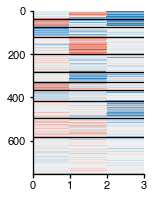

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(2,3))
ax.pcolor(clsinp,cmap=cmap,vmax=.4,vmin=-.4)
cnt = 0
for i in range(ncls):
    cnt += len(mls[i])
    ax.axhline(cnt,color='k',lw=1.3)
ax.invert_yaxis()

In [25]:
subml1 = [ m for m in clstd if clstd[m]==1 ]
subcluster = AgglomerativeClustering(n_clusters=2).fit(diffcls.reindex(subml1))
subml1 = sorted(subml1, key=lambda x:-subcluster.labels_[subml1.index(x)])

cls1 = [ m for m in clstd if clstd[m]==2 ]
cls2 = [ m for m in clstd if clstd[m]==5 ]
cls3 = [ m for m in clstd if clstd[m]==8 ]+[ m for m in clstd if clstd[m]==0 ]
cls4 = subml1+[ m for m in clstd if clstd[m]==6 ]
cls5 = [ m for m in clstd if clstd[m]==3 ]
cls6 = [ m for m in clstd if clstd[m]==9 ]+[ m for m in clstd if clstd[m]==4 ]+\
       [ m for m in clstd if clstd[m]==10 ]+[ m for m in clstd if clstd[m]==7 ]

In [26]:
clsl = [cls1,cls2,cls3,cls4,cls5,cls6]
clsinp = difftbl.reindex(clsl[0]).iloc[:,1:]
for ml in clsl[1:]:
    clsinp = clsinp.append(difftbl.reindex(ml).iloc[:,1:])

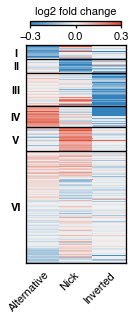

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(1.8,4))
im = ax.pcolor(clsinp, cmap=cmap, vmax=.3, vmin=-.3)
cnt = 0
for ml,name in zip(clsl,['I','II','III','IV','V','VI','VII']):
    ax.text(-.3, cnt+len(ml)/2+5, name, ha='center', va='center', fontsize=11, weight='bold')
    cnt += len(ml)
    ax.axhline(cnt,color='k',lw=1.3)
ax.invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_yticks([])
axcb = fig.add_axes([.16,.95,.7,.015])
axcb.tick_params(length=3)
fig.text(.51,.985,'log2 fold change',ha='center', fontsize=11)
cb = plt.colorbar(im, cax=axcb, orientation='horizontal')
cb.set_ticks([-.3,0,.3])
ax.set_xticks([.1,1.3,2.2])
ax.set_xticklabels(['Alternative','Nick','Inverted'],rotation=45)
ax.tick_params(bottom='off')
#fig.savefig(resultpath + '200924_f5b__clustering.pdf')#,dpi=300)

# C. Classification changes

In [28]:
single = set(s8[s8['Cleavage type']=='single'].index)
multi = set(s8[s8['Cleavage type']=='multiple'].index)
inverted = set(s8[s8['Cleavage type']=='inverted'].index)
nick5 = set(s8[s8['Cleavage type']=='nick5'].index)
nick3 = set(s8[s8['Cleavage type']=='nick3'].index)
nick = list(nick5) + list(nick3)
nonspec = set(s8[s8['Cleavage type']=='non-specific'].index)
dcsmirs = list(single) + list(multi)
nodcs = list(inverted) + list(nick) + list(nonspec)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(single), len(multi), len(inverted), len(nick), len(nonspec))
print "5' nick: %s, 3' nick: %s" % (len(nick5), len(nick3))

Productive: 681, Unproductive: 1064
Single: 589, Multiple: 92, Inverted: 102, Nick: 52, Non-specific: 910
5' nick: 26, 3' nick: 26


In [29]:
xs1 = map(lambda x: len([m for m in x if m in overlap]),
          [singlemp,multimp,nick5mp,nick3mp,invertedmp,nonspecmp])
xs2 = map(len, [single,multi,nick5,nick3,inverted,nonspec])
ys = np.arange(len(xs1))

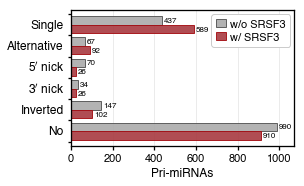

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))
ax.barh(ys-.2, xs1, height=.4, facecolor='#ababab', edgecolor='#545454',label='w/o SRSF3',
       zorder=2, alpha=.9)
ax.barh(ys+.2, xs2, height=.4, facecolor='#a83940', edgecolor='#a50f15',label='w/ SRSF3',
       zorder=2, alpha=.9)
for x1,x2,y in zip(xs1,xs2,ys):
    ax.text(x1+8,y-.2,x1,fontsize=8,va='center')
    ax.text(x2+8,y+.23,x2,fontsize=8,va='center')

ax.set_xlim(0,1070)
ax.spines['top'].set_visible(True); ax.spines['right'].set_visible(True); 
ax.legend(loc=(.63,.73), handlelength=.9,prop={'size':11},
          framealpha=1,handletextpad=.4,labelspacing=.3)
ax.invert_yaxis()
ax.xaxis.grid(ls='-',lw=.5)
ax.set_yticks(ys)
ax.set_yticks([-.5]+list(ys+.5),minor=True)
ax.set_yticklabels(['Single','Alternative','5$^\prime$ nick','3$^\prime$ nick','Inverted','No'],
                  fontsize=12,va='center')
ax.set_xlabel('Pri-miRNAs', fontsize=12)
ax.tick_params(left='off', which='major')
ax.tick_params(length=3,width=1.3, which='minor')
#fig.savefig(resultpath + '201005_f5c__classification_change.pdf')#,dpi=300)

# D. SRSF3-responsive element - tetramer motifs

In [31]:
def mirbase_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c3+1, pe-c5+1

In [32]:
cnst, cnen = 15, 19
f5seqs, f3seqs = {},{}
for mir in s8.index:
    ch, st, en, strand = get_pre_annot(mir)
    rst, ren = mirbase_to_relative_pos(mir, st, en)
    f5seqs[mir] = constseqs[mir][max(0,rst-cnen-4):rst-cnst]
    f3seqs[mir] = constseqs[mir][ren+cnst-1:min(ren+cnen+3,125)]
print f5seqs['hsa-mir-16-1'], f3seqs['hsa-mir-16-1']

GATAGCAA TACTCTAC


In [33]:
n = 4
allmotifs = nmer(n)
motbl = pd.DataFrame(index=allmotifs, columns=['p_5f','fc_5f','p_3f','fc_3f'])
for motif in allmotifs:
    for label,fseqs in zip(['5f','3f'],[f5seqs,f3seqs]):
        motml = [ m for m in s8.index if motif in fseqs[m] ]
        nomml = [ m for m in s8.index if motif not in fseqs[m] ]
        motvs = (s8['CP_w_SRSF3']-s8['CP_wo_SRSF3'])[motml].values
        nomvs = (s8['CP_w_SRSF3']-s8['CP_wo_SRSF3'])[nomml].values
        pv = ttest_ind(motvs, nomvs, equal_var=False)[1]
        fc = np.average(motvs)-np.average(nomvs)
        motbl.loc[motif,'p_%s'%label] = pv
        motbl.loc[motif,'fc_%s'%label] = fc
print len(motbl)
motbl.head(3)

256


,p_5f,fc_5f,p_3f,fc_3f
AAAA,0.836912,0.0770214,0.00698756,-1.01397
AAAT,0.626838,0.17772,0.124056,-0.78114
AAAG,0.329275,-0.399515,0.187345,-0.569721


In [34]:
motbl['padj_5f'] = sm.stats.multipletests(motbl['p_5f'],method='fdr_bh')[1]
motbl['padj_3f'] = sm.stats.multipletests(motbl['p_3f'],method='fdr_bh')[1]
motbl.head(3)

,p_5f,fc_5f,p_3f,fc_3f,padj_5f,padj_3f
AAAA,0.836912,0.0770214,0.00698756,-1.01397,0.916596,0.0331262
AAAT,0.626838,0.17772,0.124056,-0.78114,0.849884,0.281048
AAAG,0.329275,-0.399515,0.187345,-0.569721,0.63936,0.368927


In [35]:
fr = '3f'
pcut, fccut = .01, .01
xs = motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]['fc_%s'%fr]
ys = -np.log10(motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]\
['padj_%s'%fr].tolist())
xsig1 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]['fc_%s'%fr]
ysig1 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]\
['padj_%s'%fr].tolist())
xsig2 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]['fc_%s'%fr]
ysig2 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]\
['padj_%s'%fr].tolist())
print len(xs),len(ys),len(xsig1),len(ysig1),len(xsig2),len(ysig2)

ecns, fcns = '#252525', '#757575'
ecsig1, fcsig1 = '#a50f15', '#de2d26'
ecsig2, fcsig2 = '#08519c', '#3182bd'

223 223 10 10 23 23


Text(-1.15,3.1,u' UGGG AGGG\nAGAA GAGG')

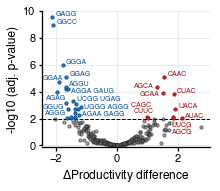

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))

ax.axhline(-np.log10(pcut), ls='--', color='k', lw=1, zorder=2)
ax.scatter(xs, ys, s=10, edgecolor=ecns, facecolor=fcns, lw=1, zorder=2, alpha=.6)
ax.scatter(xsig1, ysig1, s=10, edgecolor=ecsig1, facecolor=fcsig1, lw=1, zorder=3)
ax.scatter(xsig2, ysig2, s=10, edgecolor=ecsig2, facecolor=fcsig2, lw=1, zorder=3)

ax.set_xlabel('$\Delta$Productivity difference', fontsize=12)
ax.set_ylabel('-log10 (adj. p-value)', fontsize=12)
ax.set_xlim(min(min(xs),min(xsig2))*1.15,max(max(xs),max(xsig1))*1.1)
ax.set_ylim(-max(ysig1)*.02, max(ysig1)*1.05)
ax.set_yticks(range(0,11,2))
ax.spines['left'].set_bounds(0,10)
ax.grid(ls='-',lw=.5)

for motif in ['CAAC','CTAC','TACA','ATAC']:
    ax.text(motbl.loc[motif,'fc_%s'%fr]+.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.2,
            motif.replace('T','U'),fontsize=7,color=ecsig1,va='center')
ax.text(1.21,4.3,'AGCA',ha='right',fontsize=7,color=ecsig1)
ax.text(1.4,3.7,'GCAA',ha='right',fontsize=7,color=ecsig1)
ax.text(1.8,1.75,'UUCG\nAGCG',va='top',fontsize=7,color=ecsig1,linespacing=.9,
       bbox={'facecolor':'w','lw':0,'alpha':.6,'boxstyle':'round,pad=0.1'})
ax.text(1.2,2.4,'CAGC \nCUUC',ha='right',fontsize=7,color=ecsig1,linespacing=.9)

for motif in ['GAGG','GGCC','GGGA','GGAG','AGGT']:
    ax.text(motbl.loc[motif,'fc_%s'%fr]+.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.2,
            motif.replace('T','U'),fontsize=7,color=ecsig2,va='center')
for motif in ['GGTG','AGGG']:
    ax.text(motbl.loc[motif,'fc_%s'%fr]-.05,-np.log10(motbl.loc[motif,'padj_%s'%fr])-.3,
            motif.replace('T','U'),fontsize=7,color=ecsig2,va='center',ha='right')
ax.text(-1.5,3.9,'AGGA GAUG',fontsize=7,color=ecsig2,
        bbox={'facecolor':'w','lw':0,'alpha':.6,'pad':.1})
ax.text(-1.3,3.3,'UCGG UGAG',fontsize=7,color=ecsig2)
ax.text(-2,3.8,'AGAG',ha='center',va='top',fontsize=7,color=ecsig2)
ax.text(-2.08,4.9,'GGAA',ha='center',fontsize=7,color=ecsig2)
ax.text(-1.15,3.1,' UGGG AGGG\nAGAA GAGG',va='top',fontsize=7,color=ecsig2,linespacing=.9)
#fig.savefig(resultpath + '200924_f5d__tetramer_3p.pdf')#,dpi=300)

In [37]:
fr = '5f'
pcut, fccut = .01, .01
xs = motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]['fc_%s'%fr]
ys = -np.log10(motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]\
['padj_%s'%fr].tolist())
xsig1 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]['fc_%s'%fr]
ysig1 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]\
['padj_%s'%fr].tolist())
xsig2 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]['fc_%s'%fr]
ysig2 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]\
['padj_%s'%fr].tolist())
print len(xs),len(ys),len(xsig1),len(ysig1),len(xsig2),len(ysig2)

ecns, fcns = '#252525', '#757575'
ecsig1, fcsig1 = '#a50f15', '#de2d26'
ecsig2, fcsig2 = '#08519c', '#3182bd'

239 239 0 0 17 17


Text(-1.3,3.8,u'GUGG CAGG\n   GGAG')

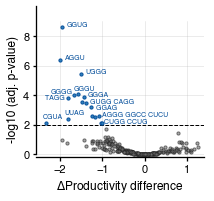

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))

ax.axhline(-np.log10(pcut), ls='--', color='k', lw=1, zorder=2)
ax.scatter(xs, ys, s=10, edgecolor=ecns, facecolor=fcns, lw=1, zorder=2, alpha=.6)
ax.scatter(xsig1, ysig1, s=10, edgecolor=ecsig1, facecolor=fcsig1, lw=1, zorder=3)
ax.scatter(xsig2, ysig2, s=10, edgecolor=ecsig2, facecolor=fcsig2, lw=1, zorder=3)

ax.set_xlabel('$\Delta$Productivity difference', fontsize=12)
ax.set_ylabel('-log10 (adj. p-value)', fontsize=12)
ax.set_xlim(min(min(xs),min(xsig2))*1.1,max(xs)*1.1)
ax.set_ylim(-max(ysig2)*.02, max(ysig2)*1.05)
ax.set_yticks(range(0,10,2))
ax.spines['left'].set_bounds(0,10)
ax.grid(ls='-',lw=.5)

for motif in ['GGTG','AGGT','TGGG','GGGA']:
    ax.text(motbl.loc[motif,'fc_%s'%fr]+.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.15,
            motif.replace('T','U'),fontsize=7,color=ecsig2,va='center')
for motif in ['CGTA','TTAG','GGGT']:
    ax.text(motbl.loc[motif,'fc_%s'%fr]+.15,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.3,
            motif.replace('T','U'),fontsize=7,color=ecsig2,ha='center')
ax.text(-1.7,3.7,'GGGG\nTAGG    ',fontsize=7,color=ecsig2,ha='right',linespacing=.9)
ax.text(-1,2.1,'AGGG GGCC CUCU\n CUGG CCUG',fontsize=7,color=ecsig2,linespacing=.95)
ax.text(-1.3,3.8,'GUGG CAGG\n   GGAG',va='top',fontsize=7,color=ecsig2,linespacing=.9)
#fig.savefig(resultpath + '200924_f5d__tetramer_5p.pdf')#,dpi=300)

# E. SRSF3-responsive element - sequence content

In [39]:
ptop = set(dcsmirsmp)&set(dcsmirs)
nptop = set(nodcsmp)&set(dcsmirs)
nptonp = set(nodcsmp)&set(nodcs)
print len(ptop), len(nptop), len(nptonp)

470 211 1030


In [40]:
nfreq = {}
for mir in f3seqs:
    if len(f3seqs[mir])>=4:
        nfreq[mir] = [ f3seqs[mir].count(nuc)/len(f3seqs[mir]) for nuc in 'ACGT' ]

In [41]:
datanpnp = zip(*[nfreq[m] for m in nptonp if m in nfreq])
norm = np.array(map(np.average, datanpnp))

datapp = zip(*[nfreq[m] for m in ptop if m in nfreq])
ypp = np.array(map(np.average, datapp))/norm; epp = map(sem,datapp)

datanpp = zip(*[nfreq[m] for m in nptop if m in nfreq])
ynpp = np.array(map(np.average, datanpp))/norm; enpp = map(sem,datanpp)

ynpnp = np.array(map(np.average, datanpnp))/norm; enpnp = map(sem,datanpnp)

xnpnp = np.arange(4)-.26
xpp = np.arange(4)
xnpp = np.arange(4)+.26
width = .23

0.3157325709336211 0.15813580983809697
5.618490359221156e-06 8.283000445433977e-05
2.0792422861389982e-10 6.684820479114099e-05
0.6971133934806897 0.23290431957316354


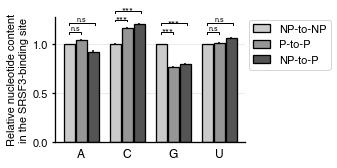

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(3.4,2.3))
ax.bar(xnpnp,ynpnp,yerr=enpnp,width=width,color='#cbcbcb',edgecolor='k',lw=1.3,zorder=2,
      label='NP-to-NP')
ax.bar(xpp,ypp,yerr=epp,width=width,color='#969696',edgecolor='k',lw=1.3,zorder=2,
      label='P-to-P')
ax.bar(xnpp,ynpp,yerr=enpp,width=width,color='#545454',edgecolor='k',lw=1.3,zorder=2,
      label='NP-to-P')
ax.set_xticks([])
ax.legend(handlelength=1.5, prop={'size':11}, loc=(1.02,.58))
for i,nuc in zip(range(4),list('ACGU')):
    ax.text(i,-.16,nuc,fontsize=12,ha='center')

for i,dy in zip(range(4),[.1,.23,.1,.1]):
    for dx in [0,.3]:
        l = lines.Line2D([i-.26,i-.26,i+dx,i+dx],
            [1+dy+dx*.3,1.02+dy+dx*.3,1.02+dy+dx*.3,1+dy+dx*.3],ls='-',lw=1,color='k')
        ax.add_line(l); l.set_clip_on(False)
        
for i,dy in zip(range(4),[.15,.28,.15,.15]):
    p1=ttest_ind(datanpnp[i],datapp[i])[1]
    p2=ttest_ind(datanpnp[i],datanpp[i])[1]
    print p1,p2
    if p1<.0005: ax.text(i-.13,1+dy-.06,'***',ha='center')
    else: ax.text(i-.13,1+dy-.01,'n.s',fontsize=7,ha='center')
    if p2<.0005: ax.text(i,1+dy+.03,'***',ha='center')
    else: ax.text(i,1+dy+.08,'n.s',fontsize=7,ha='center')
        
ax.set_ylabel('Relative nucleotide content\nin the SRSF3-binding site',fontsize=11)
ax.tick_params(bottom='off')
ax.yaxis.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '201005_f5e__nucleotide_content_v2.pdf')#,dpi=300)

# F. Secondary structure of SRSF3-responsive miRNAs

In [43]:
mirs = [m for m in nptop ]
cont = [m for m in nptonp if m in dbmirs]
print len(mirs), len(cont)

211 70


In [44]:
strintra = pd.DataFrame(index=s5.index, columns=range(1,26))
for mir in s5.index:
    ch, st, en, strand = get_pre_annot(mir)
    rst, ren = mirbase_to_relative_pos(mir, st, en)
    f3str = s5.loc[mir][ren:-1]
    f3str = dict(zip(range(1,26),[1 if s>0 else 0 for s in f3str]))
    strintra.loc[mir] = pd.Series(f3str)

In [45]:
xs = range(1,25)
ys1 = strintra.reindex(mirs)[xs].mean()*100
ys2 = strintra.reindex(cont)[xs].mean()*100

Text(18,70,u'SRSF3-\nbinding site')

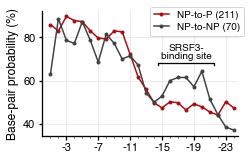

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,2.3))
ax.errorbar(xs,ys1,ms=3,marker='o',color='#a50f15',zorder=2,label='NP-to-P (%s)'%len(mirs))
ax.errorbar(xs,ys2,ms=3,marker='o',color='#424242',zorder=2,label='NP-to-NP (%s)'%len(cont))

ax.set_xlim(0,24.5)
ax.set_ylabel('Base-pair probability (%)',fontsize=12)
ax.set_xticks(range(3,25,4))
ax.set_xticks(range(1,25),minor=True)
ax.set_xticklabels([-3,-7,-11,-15,-19,-23])
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=1.5, loc=(.55,.8), prop={'size':10}, labelspacing=.3)
ax.plot([14.5,14.5,21.5,21.5],[67,68,68,67],'k-',lw=1.3)
ax.text(18,70,'SRSF3-\nbinding site',ha='center',linespacing=.95)
#fig.savefig(resultpath + '201005_f5e__basepair_frequency_intra_v2.pdf')#,dpi=300)

# G. Primary sequence motifs of SRSF3-dependent miRNAs

In [47]:
def clv_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c5+1, pe-c3+1

In [48]:
seq5tbl, seq3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))
str5tbl, str3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))

In [51]:
for mir in s8.index:
    if mir in dcsmirs:
        pres, pree = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
        rps, rpe = clv_to_relative_pos(mir, int(pres), int(pree))
    else:
        ps, pe = get_pre_annot(mir)[1:3]
        rps, rpe = mirbase_to_relative_pos(mir, ps, pe)
    priseq = constseqs[mir].replace('T','U')
    strt = [ 1 if s=='M' else 0 for s in s5.loc[mir,'symbolized structure'] ]
    seq5, str5 = priseq[max(0,rps-21):rps+29][::-1], strt[max(0,rps-21):rps+29][::-1]
    seq3, str3 = priseq[rpe-30:min(125,rpe+25)], strt[rpe-30:min(125,rpe+25)]
    pos5, pos3 = range(-20,30)[::-1], range(-25,30)[::-1]
    seq5tbl.loc[mir] = pd.Series(dict(zip(pos5,seq5)[::-1]))
    seq3tbl.loc[mir] = pd.Series(dict(zip(pos3,seq3)[::-1]))
    str5tbl.loc[mir] = pd.Series(dict(zip(pos5,str5)[::-1]))
    str3tbl.loc[mir] = pd.Series(dict(zip(pos3,str3)[::-1]))

In [52]:
seq5tbl = seq5tbl.fillna('')
str5tbl = str5tbl.fillna('')
seq3tbl = seq3tbl.fillna('')
str3tbl = str3tbl.fillna('')

In [53]:
def find_ug(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+2)].fillna(''))
    return seq=='UG'

In [54]:
def find_ugu(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+3)])
    return (seq=='UGU' or seq=='GUG')

In [55]:
def find_cnnc(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(re.search('C[A-Z][A-Z]C', seq))

In [56]:
def find_ghg(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-2,pos+1)].fillna(''))
    st = str3tbl.loc[mir,range(pos-2,pos+1)].tolist()
    return (bool(re.search('G[^G][A-Z]', seq)) and st==[1,0,1])
    #return (st==[1,0,1])

In [57]:
motifs = [ 'CNNC', 'UG', 'GHG', 'UGU' ]
ranges = { 'UG':range(-16,-11),'UGU':range(20,25),'GHG':range(-5,0), 'CNNC':range(-20,-15) }
funcs = { 'UG':find_ug, 'UGU':find_ugu, 'GHG':find_ghg, 'CNNC':find_cnnc }

In [58]:
bsfreq = defaultdict(lambda: defaultdict(int))
for mir in s8.index:
    for motif in motifs:
        for pos in ranges[motif]:
            bsfreq[motif][pos]+=int(funcs[motif](mir,pos))/len(s8.index)

In [59]:
mirls = [nptop, ptop]

In [60]:
entbls = defaultdict(lambda: pd.DataFrame())
for motif in motifs:
    for i, mirl in enumerate(mirls):
        for pos in ranges[motif]:
            freq = len([m for m in mirl if funcs[motif](m,pos)])/len(mirl)
            if freq==0:
                entbls[motif].loc[i,pos] = -1
            else:
                entbls[motif].loc[i,pos] = np.log2(freq/bsfreq[motif][pos])
                #entbls[motif].loc[i,pos] = np.log2(freq/np.average(bsfreq[motif].values()))

In [61]:
labels = [ 'NP-to-P', 'P-to-P' ]
arms = { 'UG':'5p', 'UGU':'5p', 'GHG':'3p', 'CNNC':'3p' }
cmap = custom_cmap(['#404040','#f0f0f0','#f0f0f0','#a50f15'], nspace=6)
emax, emin = 1.5, -1.5

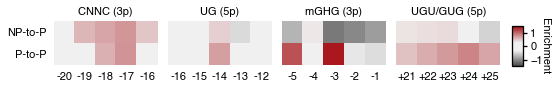

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(8,.8), sharey=True)
for motif,ax in zip(motifs,axes):
    im = ax.pcolor(entbls[motif],cmap=cmap,vmax=emax,vmin=emin)
    ax.set_xticks(np.arange(5)+.5)
    ax.set_xticklabels([i if i<0 else '+%s'%(i+1) for i in ranges[motif]])
    ax.tick_params(left='off',bottom='off')
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.set_title('%s (%s)'%(motif.replace('UGU','UGU/GUG').replace('GHG','mGHG'),arms[motif]))
ax = axes[0]
ax.invert_yaxis()
ax.set_yticks(np.arange(len(mirls))+.5)
ax.set_yticklabels(labels, fontsize=11)
axcb = fig.add_axes([.92,.1,.02,.7])
cb = plt.colorbar(im, cax=axcb); cb.set_ticks([-1,0,1])
fig.text(.97,.45,'Enrichment',va='center',rotation=270,fontsize=11)
fig.subplots_adjust(wspace=.1)
#fig.savefig(resultpath + '200929_f5g__nptop_ptop_sequence_v2.pdf')#,dpi=300)

# H. Comparison with DROSHA fCLIP-seq sites

In [64]:
s6sort = s6.sort_values('Cleavage Specificity', ascending=False)
shifted = []
for mir in ptop:
    c5 = int(s7.loc[mir,"IVP 5' site"].split(', ')[0])
    c3 = int(s7.loc[mir,"IVP 3' site"].split(', ')[0])
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if c5!=int(c5new) or c3!=int(c3new):
        shifted.append(mir)
print len(shifted)

49


In [66]:
consis, incons = [],[]
for mir in shifted:
    if mir not in s7["fCLIP 5' site"].dropna().index: continue
    fcl5cs = map(int, s7.loc[mir,"fCLIP 5' site"].split(', '))
    fcl3cs = map(int, s7.loc[mir,"fCLIP 3' site"].split(', '))
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if int(c5new) in fcl5cs and int(c3new) in fcl3cs:
        consis.append(mir)
    else:
        incons.append(mir)
print len(consis), len(incons)

18 1


In [67]:
data = [ len(consis), len(incons) ]
frac = map(lambda x:x/sum(data)*100, data)
colors = [ '#8da0cb', '#969696' ]
title = 'Cleavage sites altered by SRSF3'
labels = ['Matched with fCLIP site','Not matched']

Text(-1.25,1.4,u'Cleavage sites altered by SRSF3')

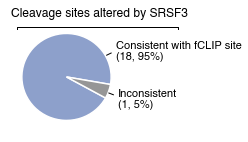

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

ps, ts = ax.pie(data,colors=colors,startangle=-10,textprops={'fontsize':12},)
for p in ps:
    p.set_linewidth(1.5)
    p.set_edgecolor('white')

ax.text(1.1,.4,'Consistent with fCLIP site\n(%s, %.0f%%)'%(data[0],frac[0]),fontsize=11)
ax.text(1.15,-.7,'Inconsistent\n(%s, %.0f%%)'%(data[1],frac[1]),fontsize=11)

l = lines.Line2D([.9,1],[.5,.55],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([.95,1.05],[-.37,-.41],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([-1.1,-1.1,2.5,2.5],[1.1,1.15,1.15,1.1],
                color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
ax.text(-1.25,1.4,title,fontsize=12)
#fig.savefig(resultpath + '201005_f5h_comparison_fCLIP.png',dpi=300)

In [69]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fcliphela = fclipexcel.parse('HeLa_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')
                     &(fclip293t['Group3p']!='Unidentified')]
bothhela = fcliphela[(fcliphela['Group5p']!='Unidentified')
                     &(fcliphela['Group3p']!='Unidentified')]

In [70]:
consis, incons = [],[]
for mir in nptop:
    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(both293t.loc[mir, 'fCLIPPosition3p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition3p']).split(';'))
    else:
        continue
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if int(c5new) in fcl5cs and int(c3new) in fcl3cs:
        consis.append(mir)
    else:
        incons.append(mir)
print len(consis), len(incons)

35 10


In [71]:
data = [ len(consis), len(incons) ]
frac = map(lambda x:x/sum(data)*100, data)
colors = [ '#66c2a5', '#969696' ]
title = 'Cleavage sites newly determined by SRSF3'
labels = ['Matched with fCLIP site','Not matched']

Text(-1.25,1.4,u'Cleavage sites newly determined by SRSF3')

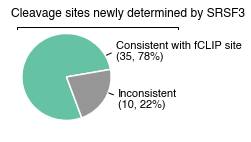

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

ps, ts = ax.pie(data,colors=colors,startangle=10,textprops={'fontsize':12},)
for p in ps:
    p.set_linewidth(1.5)
    p.set_edgecolor('white')

ax.text(1.1,.4,'Consistent with fCLIP site\n(%s, %.0f%%)'%(data[0],frac[0]),fontsize=11)
ax.text(1.15,-.7,'Inconsistent\n(%s, %.0f%%)'%(data[1],frac[1]),fontsize=11)

l = lines.Line2D([.9,1],[.5,.55],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([.95,1.05],[-.37,-.41],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([-1.1,-1.1,2.5,2.5],[1.1,1.15,1.15,1.1],
                color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
ax.text(-1.25,1.4,title,fontsize=12)
#fig.savefig(resultpath + '201005_s5h_comparison_fCLIP_nptop.png',dpi=300)